In [1]:
#从源数据文件提取并处理为18个指标：高压、低压以及合计新装增容、新装（户数、容量），然后加工出高压、低压以及合计增容（户数、容量）
#该块代码转为处理新装增容数据

import pandas as pd
import os
import re
from pathlib import Path
from typing import List, Dict, Optional
import traceback

# ==============================================================================
# 1. 配置层 (Configuration Layer)
# ==============================================================================
class Config:
    """集中管理所有可配置参数"""
    INPUT_DIR = Path(r'E:\A智网\业扩分析\数据准备\充电桩\新装增容数据')
    OUTPUT_FILE = Path(r'E:\A智网\业扩分析\12月分析\11月业扩月度报告\充电桩_25年11月业扩报告_新装增容业扩.xlsx') # 建议新文件名以防覆盖
    FILENAME_PATTERN = r'^\d{6}\.xlsx$'

    TARGET_SHEET_NAME = '国网湖北省电力有限公司'
    SKIP_ROWS = 3
    HEADER_ROWS_COUNT = 4

    ### 重构/新增开始 ###

    # --- 核心指标的最终命名 ---
    # Part 1: 从源文件直接提取的指标 (栏目 13-24)

    # 1.1 完成新装增容 (合计)
    COL_TOTAL_ALL_COUNT     = '完成新装增容_户数'
    COL_TOTAL_ALL_CAPACITY  = '完成新装增容_容量'

    # 1.2 完成新装增容 (高压)
    COL_TOTAL_HV_COUNT      = '高压完成新装增容_户数'
    COL_TOTAL_HV_CAPACITY   = '高压完成新装增容_容量'

    # 1.3 完成新装增容 (低压)
    COL_TOTAL_LV_COUNT      = '低压完成新装增容_户数'
    COL_TOTAL_LV_CAPACITY   = '低压完成新装增容_容量'

    # 1.4 完成新装 (合计)
    COL_NEW_ALL_COUNT       = '完成新装_户数'
    COL_NEW_ALL_CAPACITY    = '完成新装_容量'

    # 1.5 完成新装 (高压)
    COL_NEW_HV_COUNT        = '高压完成新装_户数'
    COL_NEW_HV_CAPACITY     = '高压完成新装_容量'

    # 1.6 完成新装 (低压)
    COL_NEW_LV_COUNT        = '低压完成新装_户数'
    COL_NEW_LV_CAPACITY     = '低压完成新装_容量'


    # Part 2: 通过计算生成的衍生指标 (增容 = 新装增容 - 新装)

    # 2.1 完成增容 (合计)
    COL_INC_ALL_COUNT       = '完成增容_户数'
    COL_INC_ALL_CAPACITY    = '完成增容_容量'

    # 2.2 完成增容 (高压)
    COL_INC_HV_COUNT        = '高压完成增容_户数'
    COL_INC_HV_CAPACITY     = '高压完成增容_容量'

    # 2.3 完成增容 (低压)
    COL_INC_LV_COUNT        = '低压完成增容_户数'
    COL_INC_LV_CAPACITY     = '低压完成增容_容量'

    ### 重构/新增结束 ###

    @staticmethod
    def get_sheets_to_create() -> Dict[str, str]:
        """
        定义要创建的所有工作表。
        字典的键 (key) 是最终Excel中的工作表名称。
        字典的值 (value) 是 long_df 中对应的数据列名。
        此方法现在将返回所有18个指标的工作表定义。
        """
        ### 重构/新增开始 ###
        sheets = {
            # 新装增容 (合计)
            Config.COL_TOTAL_ALL_COUNT:    Config.COL_TOTAL_ALL_COUNT,
            Config.COL_TOTAL_ALL_CAPACITY: Config.COL_TOTAL_ALL_CAPACITY,
            # 新装增容 (高压)
            Config.COL_TOTAL_HV_COUNT:     Config.COL_TOTAL_HV_COUNT,
            Config.COL_TOTAL_HV_CAPACITY:  Config.COL_TOTAL_HV_CAPACITY,
            # 新装增容 (低压)
            Config.COL_TOTAL_LV_COUNT:     Config.COL_TOTAL_LV_COUNT,
            Config.COL_TOTAL_LV_CAPACITY:  Config.COL_TOTAL_LV_CAPACITY,

            # 新装 (合计)
            Config.COL_NEW_ALL_COUNT:      Config.COL_NEW_ALL_COUNT,
            Config.COL_NEW_ALL_CAPACITY:   Config.COL_NEW_ALL_CAPACITY,
            # 新装 (高压)
            Config.COL_NEW_HV_COUNT:       Config.COL_NEW_HV_COUNT,
            Config.COL_NEW_HV_CAPACITY:    Config.COL_NEW_HV_CAPACITY,
            # 新装 (低压)
            Config.COL_NEW_LV_COUNT:       Config.COL_NEW_LV_COUNT,
            Config.COL_NEW_LV_CAPACITY:    Config.COL_NEW_LV_CAPACITY,

            # 增容 (合计) - 衍生
            Config.COL_INC_ALL_COUNT:      Config.COL_INC_ALL_COUNT,
            Config.COL_INC_ALL_CAPACITY:   Config.COL_INC_ALL_CAPACITY,
            # 增容 (高压) - 衍生
            Config.COL_INC_HV_COUNT:       Config.COL_INC_HV_COUNT,
            Config.COL_INC_HV_CAPACITY:    Config.COL_INC_HV_CAPACITY,
            # 增容 (低压) - 衍生
            Config.COL_INC_LV_COUNT:       Config.COL_INC_LV_COUNT,
            Config.COL_INC_LV_CAPACITY:    Config.COL_INC_LV_CAPACITY,
        }
        return sheets
        ### 重构/新增结束 ###

# ==============================================================================
# 2. 提取与解析层 (Extraction & Parsing Layer)
# ==============================================================================
def robust_to_numeric(series: pd.Series) -> pd.Series:
    """
    一个极其健壮的函数，用于清洗并转换一列可能包含文本格式数字的数据。
    它能处理千位分隔符(,)、首尾空格等常见问题。
    """
    s = series.astype(str).str.replace(',', '', regex=False).str.strip()
    return pd.to_numeric(s, errors='coerce')


def process_single_file(file_path: Path) -> Optional[pd.DataFrame]:
    """读取并处理单个Excel文件，返回一个干净的DataFrame"""
    year_month = file_path.stem
    print(f"  -> 正在处理文件: {file_path.name}")
    try:
        df = pd.read_excel(
            file_path, sheet_name=Config.TARGET_SHEET_NAME,
            skiprows=Config.SKIP_ROWS + Config.HEADER_ROWS_COUNT,
            header=None,
            dtype=str
        )

        df.rename(columns={0: '序号', 1: '行业'}, inplace=True)
        df = df[df['行业'].astype(str).str.strip() != '栏目'].copy()
        df.dropna(how='all', subset=df.columns[2:], inplace=True)
        df['序号'] = robust_to_numeric(df['序号'])
        df.dropna(subset=['序号'], inplace=True)
        df['序号'] = df['序号'].astype(int)
        df['年月'] = year_month

        df_final = df[['序号', '行业', '年月']].copy()

        ### 重构/新增开始 ###
        # 根据新需求，提取栏目13至24的数据
        # 换算公式： Pandas索引 = Excel列号 - 1
        # 原始数据栏目号从1开始，所以 Pandas索引 = 原始栏目号 + 1 (此为原代码逻辑，我们遵循它)

        # 提取 完成新装增容 数据
        df_final[Config.COL_TOTAL_ALL_COUNT]    = robust_to_numeric(df.iloc[:, 13+1]) # 栏目13
        df_final[Config.COL_TOTAL_ALL_CAPACITY] = robust_to_numeric(df.iloc[:, 14+1]) # 栏目14
        df_final[Config.COL_TOTAL_HV_COUNT]     = robust_to_numeric(df.iloc[:, 15+1]) # 栏目15
        df_final[Config.COL_TOTAL_HV_CAPACITY]  = robust_to_numeric(df.iloc[:, 16+1]) # 栏目16
        df_final[Config.COL_TOTAL_LV_COUNT]     = robust_to_numeric(df.iloc[:, 17+1]) # 栏目17
        df_final[Config.COL_TOTAL_LV_CAPACITY]  = robust_to_numeric(df.iloc[:, 18+1]) # 栏目18

        # 提取 完成新装 数据
        df_final[Config.COL_NEW_ALL_COUNT]      = robust_to_numeric(df.iloc[:, 19+1]) # 栏目19
        df_final[Config.COL_NEW_ALL_CAPACITY]   = robust_to_numeric(df.iloc[:, 20+1]) # 栏目20
        df_final[Config.COL_NEW_HV_COUNT]       = robust_to_numeric(df.iloc[:, 21+1]) # 栏目21
        df_final[Config.COL_NEW_HV_CAPACITY]    = robust_to_numeric(df.iloc[:, 22+1]) # 栏目22
        df_final[Config.COL_NEW_LV_COUNT]       = robust_to_numeric(df.iloc[:, 23+1]) # 栏目23
        df_final[Config.COL_NEW_LV_CAPACITY]    = robust_to_numeric(df.iloc[:, 24+1]) # 栏目24
        ### 重构/新增结束 ###

        return df_final
    except Exception as e:
        print(f"    [错误] 处理文件 {file_path.name} 时发生未知错误。")
        print(traceback.format_exc())
        return None

# ==============================================================================
# 3. 主流程 (Transformation & Loading)
# ==============================================================================
def main():
    print("开始执行数据处理流程...")
    all_dataframes = []
    if not Config.INPUT_DIR.exists():
        print(f"[致命错误] 输入文件夹不存在: {Config.INPUT_DIR}")
        return
    for file_path in sorted(Config.INPUT_DIR.glob('*.xlsx')):
        if re.match(Config.FILENAME_PATTERN, file_path.name):
            df = process_single_file(file_path)
            if df is not None:
                all_dataframes.append(df)
    if not all_dataframes:
        print("\n处理结束，但未从任何文件中成功提取数据。请检查上述错误日志。")
        return
    print("\n所有文件数据读取完毕，正在聚合成总表...")
    long_df = pd.concat(all_dataframes, ignore_index=True)

    long_df.fillna(0, inplace=True)

    ### 重构/新增开始 ###
    # 在聚合后的 long_df 上执行计算，生成所有“增容”相关的衍生指标
    print("正在计算所有衍生指标 (增容 = 新装增容 - 新装)...")

    # 计算 合计增容
    long_df[Config.COL_INC_ALL_COUNT]    = long_df[Config.COL_TOTAL_ALL_COUNT] - long_df[Config.COL_NEW_ALL_COUNT]
    long_df[Config.COL_INC_ALL_CAPACITY] = long_df[Config.COL_TOTAL_ALL_CAPACITY] - long_df[Config.COL_NEW_ALL_CAPACITY]

    # 计算 高压增容
    long_df[Config.COL_INC_HV_COUNT]     = long_df[Config.COL_TOTAL_HV_COUNT] - long_df[Config.COL_NEW_HV_COUNT]
    long_df[Config.COL_INC_HV_CAPACITY]  = long_df[Config.COL_TOTAL_HV_CAPACITY] - long_df[Config.COL_NEW_HV_CAPACITY]

    # 计算 低压增容
    long_df[Config.COL_INC_LV_COUNT]     = long_df[Config.COL_TOTAL_LV_COUNT] - long_df[Config.COL_NEW_LV_COUNT]
    long_df[Config.COL_INC_LV_CAPACITY]  = long_df[Config.COL_TOTAL_LV_CAPACITY] - long_df[Config.COL_NEW_LV_CAPACITY]
    ### 重构/新增结束 ###

    print("正在生成最终的多工作表Excel报表...")
    Config.OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
    with pd.ExcelWriter(Config.OUTPUT_FILE, engine='openpyxl') as writer:
        sheets_to_create = Config.get_sheets_to_create()
        # 现在的 sheets_to_create 已经包含了全部18个指标的工作表
        for sheet_name, value_col in sheets_to_create.items():
            print(f"  -> 正在生成工作表: {sheet_name}")
            try:
                pivot_df = long_df.pivot_table(
                    index=['序号', '行业'], columns='年月', values=value_col, aggfunc='sum')
                # 填充透视表中可能出现的NaN（例如某个月份某个行业没有数据）
                pivot_df.fillna(0, inplace=True)
                pivot_df.columns.name = None
                pivot_df = pivot_df.reset_index()
                pivot_df.rename(columns={'行业': '分类'}, inplace=True)
                pivot_df.to_excel(writer, sheet_name=sheet_name, index=False)
            except KeyError as e:
                print(f"    [警告] 在生成工作表 '{sheet_name}' 时找不到数据列 '{e}'，已跳过。")
                continue
    print(f"\n全部任务成功完成！结果已保存到: {Config.OUTPUT_FILE}")

if __name__ == '__main__':
    main()

开始执行数据处理流程...
  -> 正在处理文件: 202401.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202402.xlsx
  -> 正在处理文件: 202403.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202404.xlsx
  -> 正在处理文件: 202405.xlsx
  -> 正在处理文件: 202406.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202407.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202408.xlsx
  -> 正在处理文件: 202409.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202410.xlsx
  -> 正在处理文件: 202411.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202412.xlsx
  -> 正在处理文件: 202501.xlsx
  -> 正在处理文件: 202502.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202503.xlsx
  -> 正在处理文件: 202504.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202505.xlsx
  -> 正在处理文件: 202506.xlsx
  -> 正在处理文件: 202507.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202508.xlsx
  -> 正在处理文件: 202509.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202510.xlsx
  -> 正在处理文件: 202511.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")



所有文件数据读取完毕，正在聚合成总表...
正在计算所有衍生指标 (增容 = 新装增容 - 新装)...
正在生成最终的多工作表Excel报表...
  -> 正在生成工作表: 完成新装增容_户数
  -> 正在生成工作表: 完成新装增容_容量
  -> 正在生成工作表: 高压完成新装增容_户数
  -> 正在生成工作表: 高压完成新装增容_容量
  -> 正在生成工作表: 低压完成新装增容_户数
  -> 正在生成工作表: 低压完成新装增容_容量
  -> 正在生成工作表: 完成新装_户数
  -> 正在生成工作表: 完成新装_容量
  -> 正在生成工作表: 高压完成新装_户数
  -> 正在生成工作表: 高压完成新装_容量
  -> 正在生成工作表: 低压完成新装_户数
  -> 正在生成工作表: 低压完成新装_容量
  -> 正在生成工作表: 完成增容_户数
  -> 正在生成工作表: 完成增容_容量
  -> 正在生成工作表: 高压完成增容_户数
  -> 正在生成工作表: 高压完成增容_容量
  -> 正在生成工作表: 低压完成增容_户数
  -> 正在生成工作表: 低压完成增容_容量

全部任务成功完成！结果已保存到: E:\A智网\业扩分析\12月分析\11月业扩月度报告\充电桩_25年11月业扩报告_新装增容业扩.xlsx


In [2]:
#从源数据文件提取并处理为18个指标：高压、低压以及合计减容销户、销户（户数、容量），然后加工出高压、低压以及合计减容（户数、容量）
#该块代码转为处理减容销户数据

import pandas as pd
import os
import re
from pathlib import Path
from typing import List, Dict, Optional
import traceback

# ==============================================================================
# 1. 配置层 (Configuration Layer)
# ==============================================================================
class Config:
    """集中管理所有可配置参数"""
    INPUT_DIR = Path(r'E:\A智网\业扩分析\数据准备\充电桩\减容销户数据')
    OUTPUT_FILE = Path(r'E:\A智网\业扩分析\12月分析\11月业扩月度报告\充电桩_25年11月业扩报告_减容销户业扩.xlsx') # 建议新文件名以防覆盖
    FILENAME_PATTERN = r'^\d{6}\.xlsx$'

    TARGET_SHEET_NAME = '国网湖北省电力有限公司'
    SKIP_ROWS = 3
    HEADER_ROWS_COUNT = 4

    ### 重构/新增开始 ###

    # --- 核心指标的最终命名 ---
    # Part 1: 从源文件直接提取的指标 (栏目 13-24)

    # 1.1 完成减容销户 (合计)
    COL_TOTAL_ALL_COUNT     = '完成减容销户_户数'
    COL_TOTAL_ALL_CAPACITY  = '完成减容销户_容量'

    # 1.2 完成减容销户 (高压)
    COL_TOTAL_HV_COUNT      = '高压完成减容销户_户数'
    COL_TOTAL_HV_CAPACITY   = '高压完成减容销户_容量'

    # 1.3 完成减容销户 (低压)
    COL_TOTAL_LV_COUNT      = '低压完成减容销户_户数'
    COL_TOTAL_LV_CAPACITY   = '低压完成减容销户_容量'

    # 1.4 完成销户 (合计)
    COL_NEW_ALL_COUNT       = '完成销户_户数'
    COL_NEW_ALL_CAPACITY    = '完成销户_容量'

    # 1.5 完成销户 (高压)
    COL_NEW_HV_COUNT        = '高压完成销户_户数'
    COL_NEW_HV_CAPACITY     = '高压完成销户_容量'

    # 1.6 完成销户 (低压)
    COL_NEW_LV_COUNT        = '低压完成销户_户数'
    COL_NEW_LV_CAPACITY     = '低压完成销户_容量'


    # Part 2: 通过计算生成的衍生指标 (减容 = 减容销户 - 销户)

    # 2.1 完成减容 (合计)
    COL_INC_ALL_COUNT       = '完成减容_户数'
    COL_INC_ALL_CAPACITY    = '完成减容_容量'

    # 2.2 完成减容 (高压)
    COL_INC_HV_COUNT        = '高压完成减容_户数'
    COL_INC_HV_CAPACITY     = '高压完成减容_容量'

    # 2.3 完成减容 (低压)
    COL_INC_LV_COUNT        = '低压完成减容_户数'
    COL_INC_LV_CAPACITY     = '低压完成减容_容量'

    ### 重构/新增结束 ###

    @staticmethod
    def get_sheets_to_create() -> Dict[str, str]:
        """
        定义要创建的所有工作表。
        字典的键 (key) 是最终Excel中的工作表名称。
        字典的值 (value) 是 long_df 中对应的数据列名。
        此方法现在将返回所有18个指标的工作表定义。
        """
        ### 重构/新增开始 ###
        sheets = {
            # 减容销户 (合计)
            Config.COL_TOTAL_ALL_COUNT:    Config.COL_TOTAL_ALL_COUNT,
            Config.COL_TOTAL_ALL_CAPACITY: Config.COL_TOTAL_ALL_CAPACITY,
            # 减容销户 (高压)
            Config.COL_TOTAL_HV_COUNT:     Config.COL_TOTAL_HV_COUNT,
            Config.COL_TOTAL_HV_CAPACITY:  Config.COL_TOTAL_HV_CAPACITY,
            # 减容销户 (低压)
            Config.COL_TOTAL_LV_COUNT:     Config.COL_TOTAL_LV_COUNT,
            Config.COL_TOTAL_LV_CAPACITY:  Config.COL_TOTAL_LV_CAPACITY,

            # 销户 (合计)
            Config.COL_NEW_ALL_COUNT:      Config.COL_NEW_ALL_COUNT,
            Config.COL_NEW_ALL_CAPACITY:   Config.COL_NEW_ALL_CAPACITY,
            # 销户 (高压)
            Config.COL_NEW_HV_COUNT:       Config.COL_NEW_HV_COUNT,
            Config.COL_NEW_HV_CAPACITY:    Config.COL_NEW_HV_CAPACITY,
            # 销户 (低压)
            Config.COL_NEW_LV_COUNT:       Config.COL_NEW_LV_COUNT,
            Config.COL_NEW_LV_CAPACITY:    Config.COL_NEW_LV_CAPACITY,

            # 减容 (合计) - 衍生
            Config.COL_INC_ALL_COUNT:      Config.COL_INC_ALL_COUNT,
            Config.COL_INC_ALL_CAPACITY:   Config.COL_INC_ALL_CAPACITY,
            # 减容 (高压) - 衍生
            Config.COL_INC_HV_COUNT:       Config.COL_INC_HV_COUNT,
            Config.COL_INC_HV_CAPACITY:    Config.COL_INC_HV_CAPACITY,
            # 减容 (低压) - 衍生
            Config.COL_INC_LV_COUNT:       Config.COL_INC_LV_COUNT,
            Config.COL_INC_LV_CAPACITY:    Config.COL_INC_LV_CAPACITY,
        }
        return sheets
        ### 重构/新增结束 ###

# ==============================================================================
# 2. 提取与解析层 (Extraction & Parsing Layer)
# ==============================================================================
def robust_to_numeric(series: pd.Series) -> pd.Series:
    """
    一个极其健壮的函数，用于清洗并转换一列可能包含文本格式数字的数据。
    它能处理千位分隔符(,)、首尾空格等常见问题。
    """
    s = series.astype(str).str.replace(',', '', regex=False).str.strip()
    return pd.to_numeric(s, errors='coerce')


def process_single_file(file_path: Path) -> Optional[pd.DataFrame]:
    """读取并处理单个Excel文件，返回一个干净的DataFrame"""
    year_month = file_path.stem
    print(f"  -> 正在处理文件: {file_path.name}")
    try:
        df = pd.read_excel(
            file_path, sheet_name=Config.TARGET_SHEET_NAME,
            skiprows=Config.SKIP_ROWS + Config.HEADER_ROWS_COUNT,
            header=None,
            dtype=str
        )

        df.rename(columns={0: '序号', 1: '行业'}, inplace=True)
        df = df[df['行业'].astype(str).str.strip() != '栏目'].copy()
        df.dropna(how='all', subset=df.columns[2:], inplace=True)
        df['序号'] = robust_to_numeric(df['序号'])
        df.dropna(subset=['序号'], inplace=True)
        df['序号'] = df['序号'].astype(int)
        df['年月'] = year_month

        df_final = df[['序号', '行业', '年月']].copy()

        ### 重构/新增开始 ###
        # 根据新需求，提取栏目13至24的数据
        # 换算公式： Pandas索引 = Excel列号 - 1
        # 原始数据栏目号从1开始，所以 Pandas索引 = 原始栏目号 + 1 (此为原代码逻辑，我们遵循它)

        # 提取 完成减容销户 数据
        df_final[Config.COL_TOTAL_ALL_COUNT]    = robust_to_numeric(df.iloc[:, 13+1]) # 栏目13
        df_final[Config.COL_TOTAL_ALL_CAPACITY] = robust_to_numeric(df.iloc[:, 14+1]) # 栏目14
        df_final[Config.COL_TOTAL_HV_COUNT]     = robust_to_numeric(df.iloc[:, 15+1]) # 栏目15
        df_final[Config.COL_TOTAL_HV_CAPACITY]  = robust_to_numeric(df.iloc[:, 16+1]) # 栏目16
        df_final[Config.COL_TOTAL_LV_COUNT]     = robust_to_numeric(df.iloc[:, 17+1]) # 栏目17
        df_final[Config.COL_TOTAL_LV_CAPACITY]  = robust_to_numeric(df.iloc[:, 18+1]) # 栏目18

        # 提取 完成销户 数据
        df_final[Config.COL_NEW_ALL_COUNT]      = robust_to_numeric(df.iloc[:, 19+1]) # 栏目19
        df_final[Config.COL_NEW_ALL_CAPACITY]   = robust_to_numeric(df.iloc[:, 20+1]) # 栏目20
        df_final[Config.COL_NEW_HV_COUNT]       = robust_to_numeric(df.iloc[:, 21+1]) # 栏目21
        df_final[Config.COL_NEW_HV_CAPACITY]    = robust_to_numeric(df.iloc[:, 22+1]) # 栏目22
        df_final[Config.COL_NEW_LV_COUNT]       = robust_to_numeric(df.iloc[:, 23+1]) # 栏目23
        df_final[Config.COL_NEW_LV_CAPACITY]    = robust_to_numeric(df.iloc[:, 24+1]) # 栏目24
        ### 重构/新增结束 ###

        return df_final
    except Exception as e:
        print(f"    [错误] 处理文件 {file_path.name} 时发生未知错误。")
        print(traceback.format_exc())
        return None

# ==============================================================================
# 3. 主流程 (Transformation & Loading)
# ==============================================================================
def main():
    print("开始执行数据处理流程...")
    all_dataframes = []
    if not Config.INPUT_DIR.exists():
        print(f"[致命错误] 输入文件夹不存在: {Config.INPUT_DIR}")
        return
    for file_path in sorted(Config.INPUT_DIR.glob('*.xlsx')):
        if re.match(Config.FILENAME_PATTERN, file_path.name):
            df = process_single_file(file_path)
            if df is not None:
                all_dataframes.append(df)
    if not all_dataframes:
        print("\n处理结束，但未从任何文件中成功提取数据。请检查上述错误日志。")
        return
    print("\n所有文件数据读取完毕，正在聚合成总表...")
    long_df = pd.concat(all_dataframes, ignore_index=True)

    long_df.fillna(0, inplace=True)

    ### 重构/新增开始 ###
    # 在聚合后的 long_df 上执行计算，生成所有“减容”相关的衍生指标
    print("正在计算所有衍生指标 (减容 = 减容销户 - 销户)...")

    # 计算 合计减容
    long_df[Config.COL_INC_ALL_COUNT]    = long_df[Config.COL_TOTAL_ALL_COUNT] - long_df[Config.COL_NEW_ALL_COUNT]
    long_df[Config.COL_INC_ALL_CAPACITY] = long_df[Config.COL_TOTAL_ALL_CAPACITY] - long_df[Config.COL_NEW_ALL_CAPACITY]

    # 计算 高压减容
    long_df[Config.COL_INC_HV_COUNT]     = long_df[Config.COL_TOTAL_HV_COUNT] - long_df[Config.COL_NEW_HV_COUNT]
    long_df[Config.COL_INC_HV_CAPACITY]  = long_df[Config.COL_TOTAL_HV_CAPACITY] - long_df[Config.COL_NEW_HV_CAPACITY]

    # 计算 低压减容
    long_df[Config.COL_INC_LV_COUNT]     = long_df[Config.COL_TOTAL_LV_COUNT] - long_df[Config.COL_NEW_LV_COUNT]
    long_df[Config.COL_INC_LV_CAPACITY]  = long_df[Config.COL_TOTAL_LV_CAPACITY] - long_df[Config.COL_NEW_LV_CAPACITY]
    ### 重构/新增结束 ###

    print("正在生成最终的多工作表Excel报表...")
    Config.OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
    with pd.ExcelWriter(Config.OUTPUT_FILE, engine='openpyxl') as writer:
        sheets_to_create = Config.get_sheets_to_create()
        # 现在的 sheets_to_create 已经包含了全部18个指标的工作表
        for sheet_name, value_col in sheets_to_create.items():
            print(f"  -> 正在生成工作表: {sheet_name}")
            try:
                pivot_df = long_df.pivot_table(
                    index=['序号', '行业'], columns='年月', values=value_col, aggfunc='sum')
                # 填充透视表中可能出现的NaN（例如某个月份某个行业没有数据）
                pivot_df.fillna(0, inplace=True)
                pivot_df.columns.name = None
                pivot_df = pivot_df.reset_index()
                pivot_df.rename(columns={'行业': '分类'}, inplace=True)
                pivot_df.to_excel(writer, sheet_name=sheet_name, index=False)
            except KeyError as e:
                print(f"    [警告] 在生成工作表 '{sheet_name}' 时找不到数据列 '{e}'，已跳过。")
                continue
    print(f"\n全部任务成功完成！结果已保存到: {Config.OUTPUT_FILE}")

if __name__ == '__main__':
    main()

开始执行数据处理流程...
  -> 正在处理文件: 202401.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202402.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202403.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202404.xlsx
  -> 正在处理文件: 202405.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202406.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202407.xlsx
  -> 正在处理文件: 202408.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202409.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202410.xlsx
  -> 正在处理文件: 202411.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202412.xlsx
  -> 正在处理文件: 202501.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202502.xlsx
  -> 正在处理文件: 202503.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202504.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202505.xlsx
  -> 正在处理文件: 202506.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202507.xlsx
  -> 正在处理文件: 202508.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202509.xlsx
  -> 正在处理文件: 202510.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202511.xlsx

所有文件数据读取完毕，正在聚合成总表...
正在计算所有衍生指标 (减容 = 减容销户 - 销户)...
正在生成最终的多工作表Excel报表...
  -> 正在生成工作表: 完成减容销户_户数
  -> 正在生成工作表: 完成减容销户_容量


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在生成工作表: 高压完成减容销户_户数
  -> 正在生成工作表: 高压完成减容销户_容量
  -> 正在生成工作表: 低压完成减容销户_户数
  -> 正在生成工作表: 低压完成减容销户_容量
  -> 正在生成工作表: 完成销户_户数
  -> 正在生成工作表: 完成销户_容量
  -> 正在生成工作表: 高压完成销户_户数
  -> 正在生成工作表: 高压完成销户_容量
  -> 正在生成工作表: 低压完成销户_户数
  -> 正在生成工作表: 低压完成销户_容量
  -> 正在生成工作表: 完成减容_户数
  -> 正在生成工作表: 完成减容_容量
  -> 正在生成工作表: 高压完成减容_户数
  -> 正在生成工作表: 高压完成减容_容量
  -> 正在生成工作表: 低压完成减容_户数
  -> 正在生成工作表: 低压完成减容_容量

全部任务成功完成！结果已保存到: E:\A智网\业扩分析\12月分析\11月业扩月度报告\充电桩_25年11月业扩报告_减容销户业扩.xlsx


In [5]:
#月度综合报告添加近三月的净增容量对比变化


#将前期提出的新装增容、减容销户基本数据整合分析，得出所需月份的分析表文件'x月综合分析报告'，单位：万千伏安、户

import pandas as pd
from pathlib import Path
from typing import Dict, List, Optional

# ==============================================================================
# 1. 配置层 (Configuration Layer)
# ==============================================================================
class Config:
    """集中管理所有分析报告的配置参数"""
    # --- 输入路径和文件 ---
    BASE_PATH = Path(r'E:\A智网\业扩分析\12月分析\11月业扩月度报告')
    FILE_NEW_INC = BASE_PATH / '充电桩_25年11月业扩报告_新装增容业扩.xlsx'
    FILE_DEC_TERM = BASE_PATH / '充电桩_25年11月业扩报告_减容销户业扩.xlsx'

    # --- 输出文件 ---
    OUTPUT_FILE = BASE_PATH / "11月业扩月度综合分析报告_充电桩.xlsx"

    # --- 分析周期定义 ---
    # !! 关键 !!: 每次运行时，只需要修改 TARGET_MONTH
    TARGET_MONTH = '202511'

    # --- 容量单位转换配置 ---
    CAPACITY_UNIT_CONVERSION_FACTOR = 10000  # 从 kVA 转换为 万kVA
    CAPACITY_DECIMAL_PLACES = 3              # 输出容量时保留的小数位数

    # --- 指标所在的工作表名称 (Sheet Names) ---
    # ... (这部分未变，保持原样) ...
    SHEET_NEW_COUNT = '完成新装_户数'
    SHEET_NEW_CAP = '完成新装_容量'
    SHEET_INC_COUNT = '完成增容_户数'
    SHEET_INC_CAP = '完成增容_容量'
    SHEET_TOTAL_INC_CAP = '完成新装增容_容量'

    SHEET_DEC_COUNT = '完成减容_户数'
    SHEET_DEC_CAP = '完成减容_容量'
    SHEET_TERM_COUNT = '完成销户_户数'
    SHEET_TERM_CAP = '完成销户_容量'
    SHEET_TOTAL_DEC_CAP = '完成减容销户_容量'

    # --- 输出报告的列名 ---
    COL_SEQ = '序号' # <--- 修改：新增序号列的定义
    COL_CATEGORY = '分类'
    COL_NEW_COMBINED = '本月新装（户数/容量）'
    COL_INC_COMBINED = '本月增容（户数/容量）'
    COL_DEC_COMBINED = '本月减容（户数/容量）'
    COL_TERM_COMBINED = '本月销户（户数/容量）'
    COL_NET_INC_MONTH = '本月净增容量'
    COL_NET_INC_YTD = '本年累计净增容量'
    COL_NET_INC_MOM = '净增容量环比'
    COL_NET_INC_YOY = '净增容量同比'

    COL_NET_INC_LAST_3_MONTHS = '近三月净增容量(万kVA)'
    COL_NET_INC_LAST_3_MONTHS_YOY = '近三月净增容量同比'


# ==============================================================================
# 2. 辅助函数层 (Helper Functions)
# ==============================================================================
def read_single_indicator(file_path: Path, sheet_name: str, cols_to_read: List[str]) -> Optional[pd.DataFrame]:
    """从单个Excel文件的指定工作表中读取特定列"""
    print(f"  -> 正在读取: 文件 '{file_path.name}', 工作表 '{sheet_name}'")
    if not file_path.exists():
        print(f"    [错误] 文件不存在: {file_path}")
        return None
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name) # <--- 修改：先读取所有列
        # 检查所需列是否存在
        missing_cols = [col for col in cols_to_read if col not in df.columns]
        if missing_cols:
            print(f"    [警告] 工作表 '{sheet_name}' 中缺少列: {', '.join(missing_cols)}")
            # 过滤掉不存在的列，继续处理
            cols_to_read = [col for col in cols_to_read if col in df.columns]

        df = df[cols_to_read] # 只保留需要的列
        df['分类'] = df['分类'].astype(str)
        return df.set_index(Config.COL_CATEGORY)
    except (FileNotFoundError, ValueError) as e:
        print(f"    [错误] 读取失败: {e}")
        return None
    except Exception as e:
        print(f"    [严重错误] 发生未知错误: {e}")
        return None

def calculate_percentage_change(current, previous):
    """健壮的百分比变化计算函数，处理除以零的情况"""
    if pd.isna(current) or pd.isna(previous):
        return 'N/A'
    if previous == 0:
        return 'N/A'
    change = (current - previous) / abs(previous)
    return f"{change:.2%}"

# ==============================================================================
# 3. 主流程 (Main Logic)
# ==============================================================================
# ==============================================================================
# 3. 主流程 (Main Logic)
# ==============================================================================
def main():
    """主执行函数"""
    print("开始生成业扩月度综合分析报告...")

    # --- 1. 动态计算所有相关月份 ---
    try:
        current_year = int(Config.TARGET_MONTH[:4])
        current_month_num = int(Config.TARGET_MONTH[4:])
        
        # a. 单月指标所需月份
        target_month_col = Config.TARGET_MONTH
        previous_month_dt = pd.to_datetime(target_month_col, format='%Y%m') - pd.DateOffset(months=1)
        previous_month_col = previous_month_dt.strftime('%Y%m')
        last_year_month_col = f"{current_year-1}{current_month_num:02d}"
        
        # b. 本年累计所需月份
        ytd_months_cols = [f"{current_year}{m:02d}" for m in range(1, current_month_num + 1)]
        
        # c. 【新增】近三月指标所需月份
        #    今年近三月
        last_3_months_current_year = []
        for i in range(3):
            month_dt = pd.to_datetime(target_month_col, format='%Y%m') - pd.DateOffset(months=i)
            last_3_months_current_year.append(month_dt.strftime('%Y%m'))
        
        #    去年同期近三月
        last_3_months_previous_year = [f"{current_year-1}{m.split('-')[1]}" for m in pd.to_datetime(last_3_months_current_year, format='%Y%m').strftime('%Y-%m')]

        # d. 汇总所有需要从Excel读取的列
        all_required_cols = list(set(
            [Config.COL_SEQ, Config.COL_CATEGORY, target_month_col, previous_month_col, last_year_month_col] 
            + ytd_months_cols 
            + last_3_months_current_year 
            + last_3_months_previous_year
        ))
        
        print(f"分析月份: {target_month_col}")
        print(f"今年近三月: {last_3_months_current_year}")
        print(f"去年同期近三月: {last_3_months_previous_year}")

    except ValueError:
        print(f"[致命错误] 'TARGET_MONTH' ({Config.TARGET_MONTH}) 格式不正确。")
        return

    # --- 2. 读取核心数据 ---
    df_total_inc = read_single_indicator(Config.FILE_NEW_INC, Config.SHEET_TOTAL_INC_CAP, all_required_cols)
    df_total_dec = read_single_indicator(Config.FILE_DEC_TERM, Config.SHEET_TOTAL_DEC_CAP, all_required_cols)

    if df_total_inc is None or df_total_dec is None:
        print("\n[致命错误] 无法读取核心数据，程序终止。")
        return

    net_increase_df = df_total_inc.drop(columns=[Config.COL_SEQ], errors='ignore').subtract(df_total_dec.drop(columns=[Config.COL_SEQ], errors='ignore'), fill_value=0)

    # --- 3. 计算所有衍生指标 ---
    print("\n正在计算所有衍生指标...")
    summary_df = pd.DataFrame(index=net_increase_df.index)
    
    # a. 计算原有指标 (本月净增, 累计, 环比, 同比)
    summary_df[Config.COL_NET_INC_MONTH] = (net_increase_df.get(target_month_col, 0) / Config.CAPACITY_UNIT_CONVERSION_FACTOR).round(Config.CAPACITY_DECIMAL_PLACES)
    summary_df[Config.COL_NET_INC_YTD] = (net_increase_df[ytd_months_cols].sum(axis=1) / Config.CAPACITY_UNIT_CONVERSION_FACTOR).round(Config.CAPACITY_DECIMAL_PLACES)
    
    net_inc_current = net_increase_df.get(target_month_col, 0)
    net_inc_previous = net_increase_df.get(previous_month_col, 0)
    net_inc_last_year = net_increase_df.get(last_year_month_col, 0)
    summary_df[Config.COL_NET_INC_MOM] = [calculate_percentage_change(cur, prev) for cur, prev in zip(net_inc_current, net_inc_previous)]
    summary_df[Config.COL_NET_INC_YOY] = [calculate_percentage_change(cur, last) for cur, last in zip(net_inc_current, net_inc_last_year)]
    
    # b. 【新增】计算近三月指标
    #    今年近三月净增容量
    net_inc_last_3_months_current = net_increase_df[last_3_months_current_year].sum(axis=1)
    summary_df[Config.COL_NET_INC_LAST_3_MONTHS] = (net_inc_last_3_months_current / Config.CAPACITY_UNIT_CONVERSION_FACTOR).round(Config.CAPACITY_DECIMAL_PLACES)
    
    #    去年同期近三月净增容量
    net_inc_last_3_months_previous = net_increase_df[last_3_months_previous_year].sum(axis=1)
    
    #    近三月净增容量同比
    summary_df[Config.COL_NET_INC_LAST_3_MONTHS_YOY] = [
        calculate_percentage_change(cur, prev) 
        for cur, prev in zip(net_inc_last_3_months_current, net_inc_last_3_months_previous)
    ]
    
    # --- 4. 读取并组合户数/容量数据 ---
    print("\n正在读取并组合 '户数/容量' 数据...")
    cols_for_combined = [Config.COL_CATEGORY, target_month_col]
    
    df_new_count  = read_single_indicator(Config.FILE_NEW_INC, Config.SHEET_NEW_COUNT, cols_for_combined)
    df_new_cap    = read_single_indicator(Config.FILE_NEW_INC, Config.SHEET_NEW_CAP, cols_for_combined)
    # ... (此处省略其他户数/容量的读取，逻辑不变)
    df_inc_count  = read_single_indicator(Config.FILE_NEW_INC, Config.SHEET_INC_COUNT, cols_for_combined)
    df_inc_cap    = read_single_indicator(Config.FILE_NEW_INC, Config.SHEET_INC_CAP, cols_for_combined)
    df_dec_count  = read_single_indicator(Config.FILE_DEC_TERM, Config.SHEET_DEC_COUNT, cols_for_combined)
    df_dec_cap    = read_single_indicator(Config.FILE_DEC_TERM, Config.SHEET_DEC_CAP, cols_for_combined)
    df_term_count = read_single_indicator(Config.FILE_DEC_TERM, Config.SHEET_TERM_COUNT, cols_for_combined)
    df_term_cap   = read_single_indicator(Config.FILE_DEC_TERM, Config.SHEET_TERM_CAP, cols_for_combined)


    def combine_count_cap(df_count, df_cap):
        if df_count is None or df_cap is None: return "N/A"
        count_s = df_count.get(target_month_col, 0).reindex(summary_df.index).fillna(0).astype(int)
        cap_raw = df_cap.get(target_month_col, 0).reindex(summary_df.index).fillna(0).astype(float)
        cap_converted = (cap_raw / Config.CAPACITY_UNIT_CONVERSION_FACTOR).round(Config.CAPACITY_DECIMAL_PLACES)
        return count_s.astype(str) + '/' + cap_converted.astype(str)

    summary_df[Config.COL_NEW_COMBINED] = combine_count_cap(df_new_count, df_new_cap)
    summary_df[Config.COL_INC_COMBINED] = combine_count_cap(df_inc_count, df_inc_cap)
    summary_df[Config.COL_DEC_COMBINED] = combine_count_cap(df_dec_count, df_dec_cap)
    summary_df[Config.COL_TERM_COMBINED] = combine_count_cap(df_term_count, df_term_cap)

    # --- 5. 整理并输出最终报告 ---
    print("\n正在生成最终报告...")
    
    if Config.COL_SEQ in df_total_inc.columns:
        summary_df = summary_df.join(df_total_inc[[Config.COL_SEQ]])
    else:
        summary_df[Config.COL_SEQ] = 'N/A'

    final_df = summary_df.reset_index()

    # 【已更新】调整最终的列顺序，加入新指标
    final_cols_order = [
        Config.COL_SEQ,
        Config.COL_CATEGORY,
        Config.COL_NEW_COMBINED,
        Config.COL_INC_COMBINED,
        Config.COL_DEC_COMBINED,
        Config.COL_TERM_COMBINED,
        Config.COL_NET_INC_MONTH,
        Config.COL_NET_INC_YTD,
        Config.COL_NET_INC_LAST_3_MONTHS, # <--- 新增列
        Config.COL_NET_INC_MOM,
        Config.COL_NET_INC_YOY,
        Config.COL_NET_INC_LAST_3_MONTHS_YOY, # <--- 新增列
    ]
    
    final_df = final_df[final_cols_order]

    try:
        Config.OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
        final_df.to_excel(Config.OUTPUT_FILE, sheet_name='月度综合分析', index=False)
        print(f"\n全部任务成功完成！结果已保存到: {Config.OUTPUT_FILE}")
    except Exception as e:
        print(f"\n[致命错误] 保存Excel文件失败: {e}")

if __name__ == '__main__':
    main()


开始生成业扩月度综合分析报告...
分析月份: 202511
今年近三月: ['202511', '202510', '202509']
去年同期近三月: ['202411', '202410', '202409']
  -> 正在读取: 文件 '充电桩_25年11月业扩报告_新装增容业扩.xlsx', 工作表 '完成新装增容_容量'
  -> 正在读取: 文件 '充电桩_25年11月业扩报告_减容销户业扩.xlsx', 工作表 '完成减容销户_容量'

正在计算所有衍生指标...

正在读取并组合 '户数/容量' 数据...
  -> 正在读取: 文件 '充电桩_25年11月业扩报告_新装增容业扩.xlsx', 工作表 '完成新装_户数'
  -> 正在读取: 文件 '充电桩_25年11月业扩报告_新装增容业扩.xlsx', 工作表 '完成新装_容量'
  -> 正在读取: 文件 '充电桩_25年11月业扩报告_新装增容业扩.xlsx', 工作表 '完成增容_户数'
  -> 正在读取: 文件 '充电桩_25年11月业扩报告_新装增容业扩.xlsx', 工作表 '完成增容_容量'
  -> 正在读取: 文件 '充电桩_25年11月业扩报告_减容销户业扩.xlsx', 工作表 '完成减容_户数'
  -> 正在读取: 文件 '充电桩_25年11月业扩报告_减容销户业扩.xlsx', 工作表 '完成减容_容量'
  -> 正在读取: 文件 '充电桩_25年11月业扩报告_减容销户业扩.xlsx', 工作表 '完成销户_户数'
  -> 正在读取: 文件 '充电桩_25年11月业扩报告_减容销户业扩.xlsx', 工作表 '完成销户_容量'

正在生成最终报告...

全部任务成功完成！结果已保存到: E:\A智网\业扩分析\12月分析\11月业扩月度报告\11月业扩月度综合分析报告_充电桩.xlsx


In [6]:
import pandas as pd
from pathlib import Path
import traceback

# ==============================================================================
# 1. 配置层 (Configuration Layer)
# ==============================================================================
class Config:
    """集中管理所有分析报告的配置参数"""
    # --- 输入路径和文件 ---
    BASE_PATH = Path(r'E:\A智网\业扩分析\12月分析\11月业扩月度报告')
    FILE_NEW_INC = BASE_PATH / '充电桩_25年11月业扩报告_新装增容业扩.xlsx'
    FILE_DEC_TERM = BASE_PATH / '充电桩_25年11月业扩报告_减容销户业扩.xlsx'

    # --- 输出文件 ---
    # 我们将结果写入一个新的专用文件中，以防覆盖原有报告
    OUTPUT_FILE = BASE_PATH / '充电桩_业扩月度累计净增容量趋势分析.xlsx'

    # --- 指标所在的工作表名称 ---
    SHEET_TOTAL_INC_CAP = '完成新装增容_容量'
    SHEET_TOTAL_DEC_CAP = '完成减容销户_容量'

    # --- 关键列名 ---
    COL_SEQ = '序号'
    COL_CATEGORY = '分类'
    
    # --- 输出Sheet和列名 ---
    OUTPUT_SHEET_YTD_CAP = '累计净增容量'
    OUTPUT_SHEET_YTD_YOY = '累计净增容量同比'
    
    # --- 容量单位转换 ---
    CAPACITY_UNIT_CONVERSION_FACTOR = 10000  # 从 kVA 转换为 万kVA
    CAPACITY_DECIMAL_PLACES = 3

# ==============================================================================
# 2. 辅助函数层 (Helper Functions)
# ==============================================================================
def calculate_percentage_change(current, previous):
    """健壮的百分比变化计算函数"""
    if pd.isna(current) or pd.isna(previous):
        return 'N/A'
    if previous == 0:
        return 'N/A' if current != 0 else '0.00%'
    change = (current - previous) / abs(previous)
    return f"{change:.2%}"

# ==============================================================================
# 3. 主流程 (Main Logic)
# ==============================================================================
def main():
    """主执行函数"""
    print("--- 开始生成累计净增容量趋势分析报告 ---")

    try:
        # --- 1. 读取并准备核心数据 ---
        print("正在读取核心数据文件...")
        df_inc = pd.read_excel(Config.FILE_NEW_INC, sheet_name=Config.SHEET_TOTAL_INC_CAP)
        df_inc.columns = df_inc.columns.map(str)
        
        df_dec = pd.read_excel(Config.FILE_DEC_TERM, sheet_name=Config.SHEET_TOTAL_DEC_CAP)
        df_dec.columns = df_dec.columns.map(str)

        id_cols = [Config.COL_SEQ, Config.COL_CATEGORY]
        month_cols_inc = [col for col in df_inc.columns if col.isdigit() and len(col) == 6]
        month_cols_dec = [col for col in df_dec.columns if col.isdigit() and len(col) == 6]
        all_month_cols = sorted(list(set(month_cols_inc + month_cols_dec)))

        # 将'分类'设为索引，方便计算
        # 【修正】在设置索引前，先确保'分类'列存在
        if Config.COL_CATEGORY not in df_inc.columns or Config.COL_CATEGORY not in df_dec.columns:
            print(f"[致命错误] 源文件中缺少关键列 '{Config.COL_CATEGORY}'。")
            return
        df_inc.set_index(Config.COL_CATEGORY, inplace=True)
        df_dec.set_index(Config.COL_CATEGORY, inplace=True)
        
        net_increase_df = df_inc[month_cols_inc].subtract(df_dec[month_cols_dec], fill_value=0)
        print("每月净增容量计算完成。")

        # --- 2. 循环计算每个月的累计值和同比 ---
        print("正在循环计算每个月的累计指标...")
        ytd_capacity_results = {}
        ytd_yoy_results = {}

        for month_str in all_month_cols:
            try:
                current_year = int(month_str[:4])
                current_month_num = int(month_str[4:])
                
                ytd_cols_current = [f"{current_year}{m:02d}" for m in range(1, current_month_num + 1)]
                ytd_cols_current = [col for col in ytd_cols_current if col in net_increase_df.columns]
                
                ytd_cols_previous = [f"{current_year - 1}{m:02d}" for m in range(1, current_month_num + 1)]
                ytd_cols_previous = [col for col in ytd_cols_previous if col in net_increase_df.columns]

                if not ytd_cols_current:
                    continue

                ytd_cap_current = net_increase_df[ytd_cols_current].sum(axis=1)
                ytd_capacity_results[month_str] = (ytd_cap_current / Config.CAPACITY_UNIT_CONVERSION_FACTOR).round(Config.CAPACITY_DECIMAL_PLACES)

                if ytd_cols_previous:
                    ytd_cap_previous = net_increase_df[ytd_cols_previous].sum(axis=1)
                    yoy_series = pd.Series(
                        [calculate_percentage_change(cur, prev) for cur, prev in zip(ytd_cap_current, ytd_cap_previous)],
                        index=net_increase_df.index
                    )
                    ytd_yoy_results[month_str] = yoy_series
                else:
                    ytd_yoy_results[month_str] = 'N/A'
            
            except Exception as e:
                print(f"  [警告] 处理月份 {month_str} 时出错: {e}")
                continue
        
        print("所有月份累计指标计算完成。")

        # --- 3. 组装最终报告 ---
        print("\n正在组装最终报告...")
        report_ytd_cap = pd.DataFrame(ytd_capacity_results)
        report_ytd_yoy = pd.DataFrame(ytd_yoy_results)
        
        # 提取包含'序号'和'分类'的标识DataFrame
        # 【修正】从原始df_inc中提取，因为它没有被修改索引
        id_df = pd.read_excel(Config.FILE_NEW_INC, sheet_name=Config.SHEET_TOTAL_INC_CAP)[id_cols]
        id_df.columns = id_df.columns.map(str) # 确保列名是字符串
        
        # 【核心修正】使用正确的列名进行合并
        # reset_index() 会创建一个名为'分类'的列
        report_ytd_cap = pd.merge(id_df, report_ytd_cap.reset_index(), left_on=Config.COL_CATEGORY, right_on=Config.COL_CATEGORY)
        report_ytd_yoy = pd.merge(id_df, report_ytd_yoy.reset_index(), left_on=Config.COL_CATEGORY, right_on=Config.COL_CATEGORY)

        # --- 4. 写入Excel ---
        print(f"正在将结果写入到文件: {Config.OUTPUT_FILE}")
        with pd.ExcelWriter(Config.OUTPUT_FILE, engine='openpyxl') as writer:
            report_ytd_cap.to_excel(writer, sheet_name=Config.OUTPUT_SHEET_YTD_CAP, index=False)
            print(f"  -> 已写入Sheet: '{Config.OUTPUT_SHEET_YTD_CAP}'")
            
            report_ytd_yoy.to_excel(writer, sheet_name=Config.OUTPUT_SHEET_YTD_YOY, index=False)
            print(f"  -> 已写入Sheet: '{Config.OUTPUT_SHEET_YTD_YOY}'")

        print(f"\n--- 全部任务成功完成！结果已保存到: {Config.OUTPUT_FILE} ---")

    except FileNotFoundError:
        print(f"[致命错误] 无法找到输入文件，请检查路径: {Config.FILE_NEW_INC} 或 {Config.FILE_DEC_TERM}")
    except Exception as e:
        print(f"[致命错误] 执行主流程时发生未知错误。")
        print(traceback.format_exc())

if __name__ == '__main__':
    main()

--- 开始生成累计净增容量趋势分析报告 ---
正在读取核心数据文件...
每月净增容量计算完成。
正在循环计算每个月的累计指标...
所有月份累计指标计算完成。

正在组装最终报告...
正在将结果写入到文件: E:\A智网\业扩分析\12月分析\11月业扩月度报告\充电桩_业扩月度累计净增容量趋势分析.xlsx
  -> 已写入Sheet: '累计净增容量'
  -> 已写入Sheet: '累计净增容量同比'

--- 全部任务成功完成！结果已保存到: E:\A智网\业扩分析\12月分析\11月业扩月度报告\充电桩_业扩月度累计净增容量趋势分析.xlsx ---


In [7]:
#月度综合报告添加近三月的净增容量对比变化
#添加了累计增容和累计增速11.13
#将前期提出的新装增容、减容销户基本数据整合分析，得出所需月份的分析表文件'x月综合分析报告'，单位：万千伏安、户

import pandas as pd
from pathlib import Path
from typing import Dict, List, Optional

# ==============================================================================
# 1. 配置层 (Configuration Layer)
# ==============================================================================
class Config:
    """集中管理所有分析报告的配置参数"""
    # --- 输入路径和文件 ---
    BASE_PATH = Path(r'E:\A智网\业扩分析\12月分析\11月业扩月度报告')
    FILE_NEW_INC = BASE_PATH / '充电桩_25年11月业扩报告_新装增容业扩.xlsx'
    FILE_DEC_TERM = BASE_PATH / '充电桩_25年11月业扩报告_减容销户业扩.xlsx'

    # --- 输出文件 ---
    OUTPUT_FILE = BASE_PATH / '充电桩_11月业扩月度综合分析报告v4.xlsx'

    # --- 分析周期定义 ---
    TARGET_MONTH = '202511'

    # --- 容量单位转换配置 ---
    CAPACITY_UNIT_CONVERSION_FACTOR = 10000
    CAPACITY_DECIMAL_PLACES = 3

    # --- 指标所在的工作表名称 ---
    SHEET_NEW_COUNT = '完成新装_户数'
    SHEET_NEW_CAP = '完成新装_容量'
    SHEET_INC_COUNT = '完成增容_户数'
    SHEET_INC_CAP = '完成增容_容量'
    SHEET_TOTAL_INC_CAP = '完成新装增容_容量'
    SHEET_DEC_COUNT = '完成减容_户数'
    SHEET_DEC_CAP = '完成减容_容量'
    SHEET_TERM_COUNT = '完成销户_户数'
    SHEET_TERM_CAP = '完成销户_容量'
    SHEET_TOTAL_DEC_CAP = '完成减容销户_容量'

    # --- 输出报告的列名 ---
    COL_SEQ = '序号'
    COL_CATEGORY = '分类'
    COL_NEW_COMBINED = '本月新装(户/万kVA)'
    COL_INC_COMBINED = '本月增容(户/-万kVA)'
    COL_DEC_COMBINED = '本月减容(户/万kVA)'
    COL_TERM_COMBINED = '本月销户(户/万kVA)'
    COL_NET_INC_MONTH = '本月净增容量(万kVA)'
    COL_NET_INC_YTD = '本月累计净增容量(万kVA)'
    COL_NET_INC_MOM = '净增容量环比'
    COL_NET_INC_YOY = '净增容量同比'
    COL_NET_INC_YTD_YOY = '本月累计净增容量同比'
    COL_NET_INC_LAST_3_MONTHS = '近三月净增容量(万kVA)'
    COL_NET_INC_LAST_3_MONTHS_YOY = '近三月净增容量同比'


# ==============================================================================
# 2. 辅助函数层 (Helper Functions)
# ==============================================================================
def read_single_indicator(file_path: Path, sheet_name: str, cols_to_read: List[str]) -> Optional[pd.DataFrame]:
    """从单个Excel文件的指定工作表中读取特定列"""
    print(f"  -> 正在读取: 文件 '{file_path.name}', 工作表 '{sheet_name}'")
    if not file_path.exists():
        print(f"    [错误] 文件不存在: {file_path}")
        return None
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name) # <--- 修改：先读取所有列
        # 检查所需列是否存在
        missing_cols = [col for col in cols_to_read if col not in df.columns]
        if missing_cols:
            print(f"    [警告] 工作表 '{sheet_name}' 中缺少列: {', '.join(missing_cols)}")
            # 过滤掉不存在的列，继续处理
            cols_to_read = [col for col in cols_to_read if col in df.columns]

        df = df[cols_to_read] # 只保留需要的列
        df['分类'] = df['分类'].astype(str)
        return df.set_index(Config.COL_CATEGORY)
    except (FileNotFoundError, ValueError) as e:
        print(f"    [错误] 读取失败: {e}")
        return None
    except Exception as e:
        print(f"    [严重错误] 发生未知错误: {e}")
        return None

def calculate_percentage_change(current, previous):
    """健壮的百分比变化计算函数，处理除以零的情况"""
    if pd.isna(current) or pd.isna(previous):
        return 'N/A'
    if previous == 0:
        return 'N/A'
    change = (current - previous) / abs(previous)
    return f"{change:.2%}"


# ==============================================================================
# 3. 主流程 (Main Logic)
# ==============================================================================
def main():
    """主执行函数"""
    print("开始生成业扩月度综合分析报告...")

    # --- 1. 动态计算所有相关月份 ---
    try:
        current_year = int(Config.TARGET_MONTH[:4])
        current_month_num = int(Config.TARGET_MONTH[4:])
        
        target_month_col = Config.TARGET_MONTH
        previous_month_dt = pd.to_datetime(target_month_col, format='%Y%m') - pd.DateOffset(months=1)
        previous_month_col = previous_month_dt.strftime('%Y%m')
        last_year_month_col = f"{current_year-1}{current_month_num:02d}"
        
        # 本年累计所需月份
        ytd_months_cols_current = [f"{current_year}{m:02d}" for m in range(1, current_month_num + 1)]
        
        # 【新增】去年同期累计所需月份
        ytd_months_cols_previous = [f"{current_year-1}{m:02d}" for m in range(1, current_month_num + 1)]
        
        # 近三月指标所需月份
        last_3_months_current_year = [(pd.to_datetime(target_month_col, format='%Y%m') - pd.DateOffset(months=i)).strftime('%Y%m') for i in range(3)]
        last_3_months_previous_year = [str(int(m[:4]) - 1) + m[4:] for m in last_3_months_current_year]

        # 汇总所有需要从Excel读取的列
        all_required_cols = list(set(
            [Config.COL_SEQ, Config.COL_CATEGORY, target_month_col, previous_month_col, last_year_month_col] 
            + ytd_months_cols_current 
            + ytd_months_cols_previous # <--- 新增
            + last_3_months_current_year 
            + last_3_months_previous_year
        ))
        
        print(f"分析月份: {target_month_col}")
        print(f"今年累计月份: {ytd_months_cols_current}")
        print(f"去年累计月份: {ytd_months_cols_previous}")

    except ValueError:
        print(f"[致命错误] 'TARGET_MONTH' ({Config.TARGET_MONTH}) 格式不正确。")
        return

    # --- 2. 读取核心数据 ---
    df_total_inc = read_single_indicator(Config.FILE_NEW_INC, Config.SHEET_TOTAL_INC_CAP, all_required_cols)
    df_total_dec = read_single_indicator(Config.FILE_DEC_TERM, Config.SHEET_TOTAL_DEC_CAP, all_required_cols)

    if df_total_inc is None or df_total_dec is None:
        print("\n[致命错误] 无法读取核心数据，程序终止。")
        return

    net_increase_df = df_total_inc.drop(columns=[Config.COL_SEQ], errors='ignore').subtract(df_total_dec.drop(columns=[Config.COL_SEQ], errors='ignore'), fill_value=0)

    # --- 3. 计算所有衍生指标 ---
    print("\n正在计算所有衍生指标...")
    summary_df = pd.DataFrame(index=net_increase_df.index)
    
    # a. 计算原有指标
    summary_df[Config.COL_NET_INC_MONTH] = (net_increase_df.get(target_month_col, 0) / Config.CAPACITY_UNIT_CONVERSION_FACTOR).round(Config.CAPACITY_DECIMAL_PLACES)
    
    # 今年累计
    net_inc_ytd_current = net_increase_df[ytd_months_cols_current].sum(axis=1)
    summary_df[Config.COL_NET_INC_YTD] = (net_inc_ytd_current / Config.CAPACITY_UNIT_CONVERSION_FACTOR).round(Config.CAPACITY_DECIMAL_PLACES)
    
    net_inc_current = net_increase_df.get(target_month_col, 0)
    net_inc_previous = net_increase_df.get(previous_month_col, 0)
    net_inc_last_year = net_increase_df.get(last_year_month_col, 0)
    summary_df[Config.COL_NET_INC_MOM] = [calculate_percentage_change(cur, prev) for cur, prev in zip(net_inc_current, net_inc_previous)]
    summary_df[Config.COL_NET_INC_YOY] = [calculate_percentage_change(cur, last) for cur, last in zip(net_inc_current, net_inc_last_year)]
    
    # b. 计算近三月指标
    net_inc_last_3_months_current = net_increase_df[last_3_months_current_year].sum(axis=1)
    summary_df[Config.COL_NET_INC_LAST_3_MONTHS] = (net_inc_last_3_months_current / Config.CAPACITY_UNIT_CONVERSION_FACTOR).round(Config.CAPACITY_DECIMAL_PLACES)
    
    net_inc_last_3_months_previous = net_increase_df[last_3_months_previous_year].sum(axis=1)
    
    summary_df[Config.COL_NET_INC_LAST_3_MONTHS_YOY] = [
        calculate_percentage_change(cur, prev) 
        for cur, prev in zip(net_inc_last_3_months_current, net_inc_last_3_months_previous)
    ]
    
    # c. 【新增】计算本月止累计净增容量同比
    #    去年同期累计
    net_inc_ytd_previous = net_increase_df[ytd_months_cols_previous].sum(axis=1)
    
    #    计算同比
    summary_df[Config.COL_NET_INC_YTD_YOY] = [
        calculate_percentage_change(cur, prev)
        for cur, prev in zip(net_inc_ytd_current, net_inc_ytd_previous)
    ]
    
    # --- 4. 读取并组合户数/容量数据 ---
    # (这部分逻辑完全不变)
    print("\n正在读取并组合 '户数/容量' 数据...")
    # ... (省略) ...
    
    # --- 5. 整理并输出最终报告 ---
    print("\n正在生成最终报告...")
    
    if Config.COL_SEQ in df_total_inc.columns:
        summary_df = summary_df.join(df_total_inc[[Config.COL_SEQ]])
    else:
        summary_df[Config.COL_SEQ] = 'N/A'

    final_df = summary_df.reset_index()

    # 【已更新】调整最终的列顺序，加入新指标
    final_cols_order = [
        Config.COL_SEQ,
        Config.COL_CATEGORY,
        Config.COL_NEW_COMBINED,
        Config.COL_INC_COMBINED,
        Config.COL_DEC_COMBINED,
        Config.COL_TERM_COMBINED,
        Config.COL_NET_INC_MONTH, #本月净增容
        Config.COL_NET_INC_YTD, # 累计净增容
        Config.COL_NET_INC_LAST_3_MONTHS, #近三月净增容
        Config.COL_NET_INC_YTD_YOY, # 累计净增容同比
        Config.COL_NET_INC_LAST_3_MONTHS_YOY, #近三月净增容同比
        Config.COL_NET_INC_MOM,  #环比
        Config.COL_NET_INC_YOY,  #同比
    ]
    
    # 健壮性处理：只保留实际存在的列，以防某些列计算失败
    final_df = final_df[[col for col in final_cols_order if col in final_df.columns]]

    try:
        Config.OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
        final_df.to_excel(Config.OUTPUT_FILE, sheet_name='月度综合分析', index=False)
        print(f"\n全部任务成功完成！结果已保存到: {Config.OUTPUT_FILE}")
    except Exception as e:
        print(f"\n[致命错误] 保存Excel文件失败: {e}")

if __name__ == '__main__':
    main()

开始生成业扩月度综合分析报告...
分析月份: 202511
今年累计月份: ['202501', '202502', '202503', '202504', '202505', '202506', '202507', '202508', '202509', '202510', '202511']
去年累计月份: ['202401', '202402', '202403', '202404', '202405', '202406', '202407', '202408', '202409', '202410', '202411']
  -> 正在读取: 文件 '充电桩_25年11月业扩报告_新装增容业扩.xlsx', 工作表 '完成新装增容_容量'
  -> 正在读取: 文件 '充电桩_25年11月业扩报告_减容销户业扩.xlsx', 工作表 '完成减容销户_容量'

正在计算所有衍生指标...

正在读取并组合 '户数/容量' 数据...

正在生成最终报告...

全部任务成功完成！结果已保存到: E:\A智网\业扩分析\12月分析\11月业扩月度报告\充电桩_11月业扩月度综合分析报告v4.xlsx


正在严格查找指定的字体: 'SimHei'...
成功找到字体 'SimHei'，路径: C:\Windows\Fonts\simhei.ttf

开始生成综合可视化图表: 乡村充换电业扩净增变更情况 (2024-2025)
开始读取和预处理【月度净增容量】数据...
开始读取和预处理【累计同比】数据...
数据截断与重塑完成。

图表已成功保存到: E:\A智网\业扩分析\12月分析\11月业扩月度报告\乡村充换电_综合分析图_v5_final.png


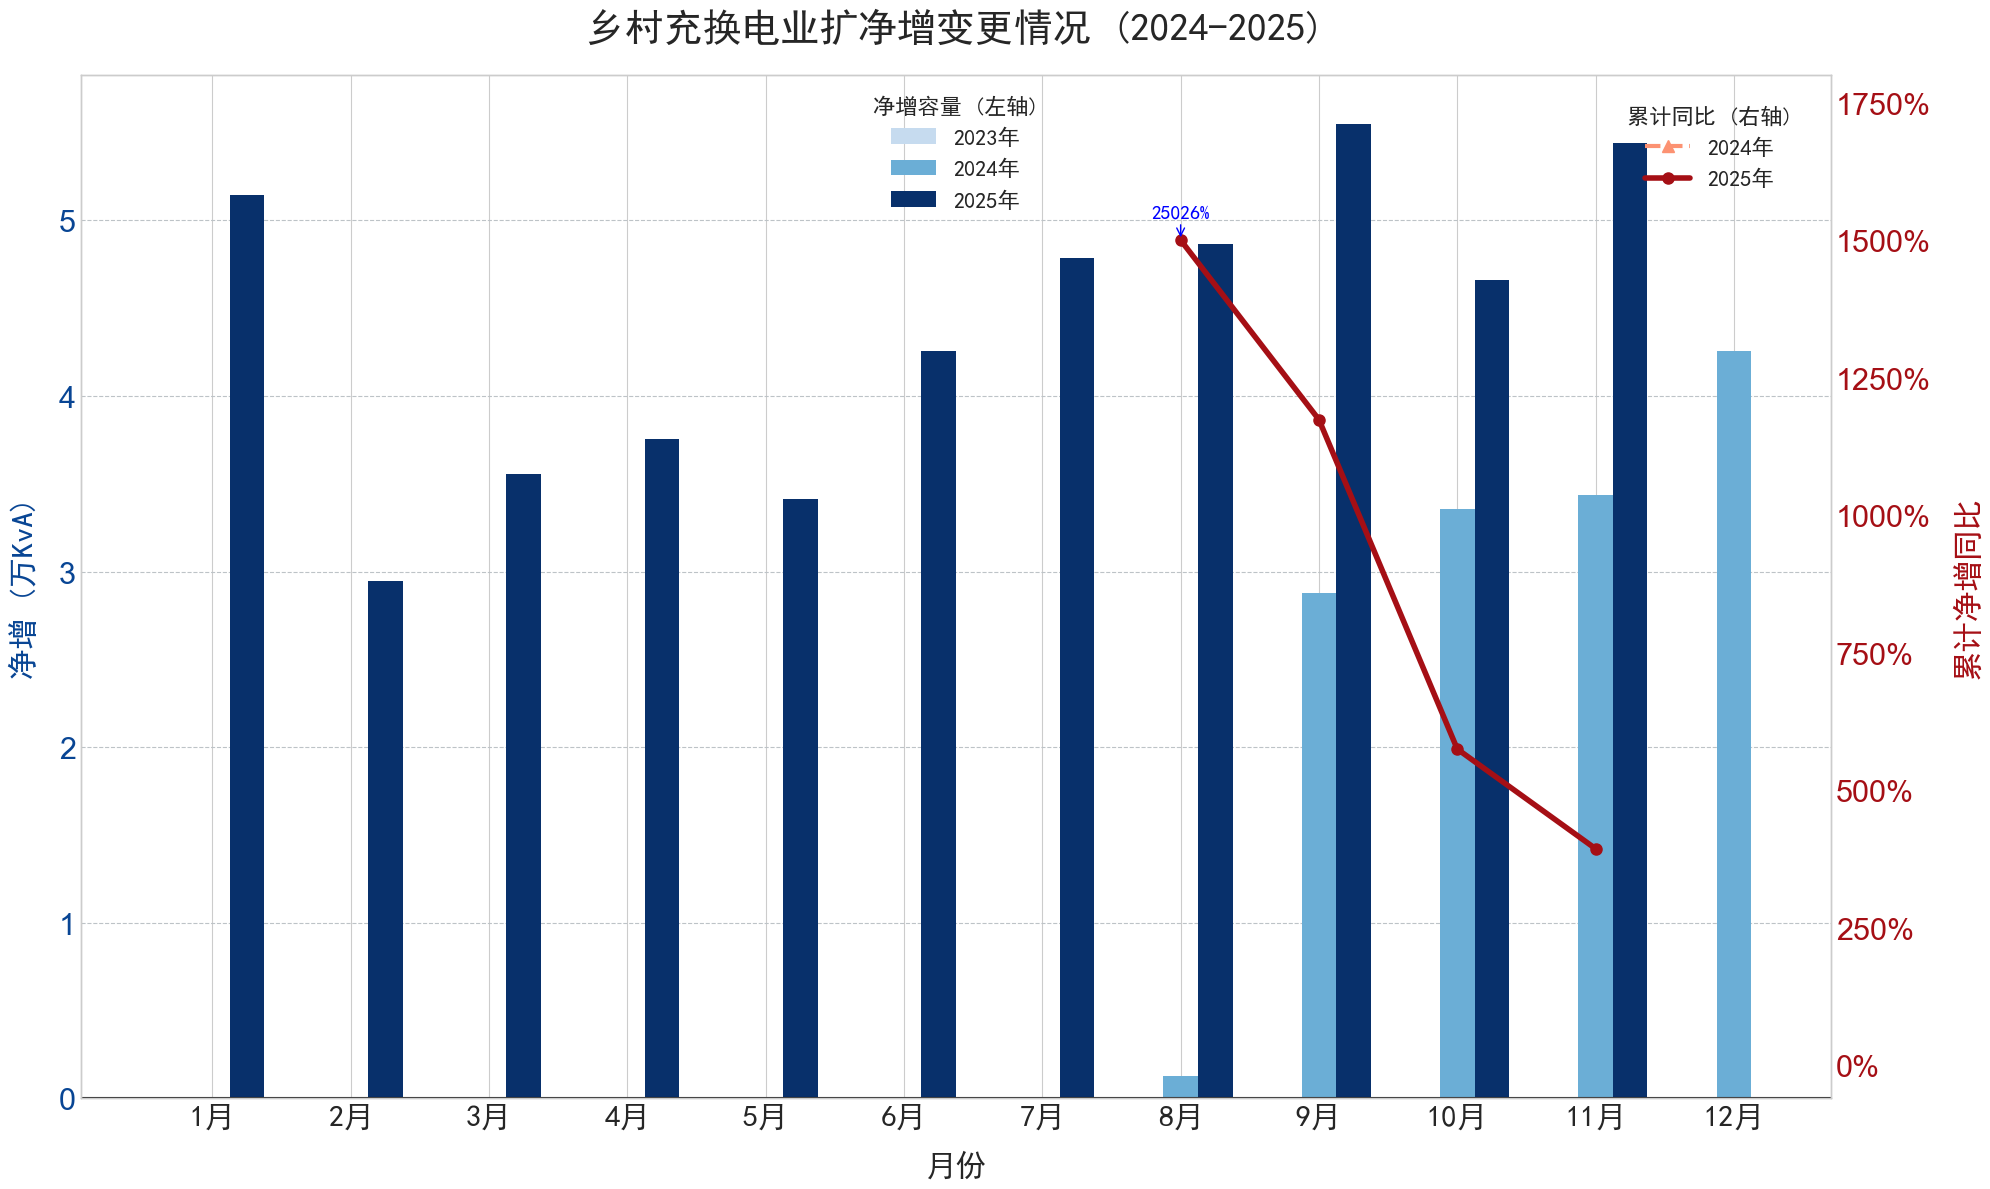

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Optional, List, Dict, Tuple
from matplotlib import font_manager
import numpy as np
from matplotlib.legend import Legend

# ==============================================================================
# 1. 配置层 (Configuration Layer)
# ==============================================================================
class Config:
    """集中管理所有绘图的配置参数"""
    BASE_PATH = Path(r'E:\A智网\业扩分析\12月分析\11月业扩月度报告')
    
    FILE_NET_INCREASE = BASE_PATH / '充电桩_25年11月业扩报告_新装增容业扩.xlsx'
    FILE_NET_DECREASE = BASE_PATH / '充电桩_25年11月业扩报告_减容销户业扩.xlsx'
    FILE_YOY_TREND = BASE_PATH / '充电桩_业扩月度累计净增容量趋势分析.xlsx'

    TARGET_CATEGORY_NAME = '  乡村居住区充换电设施用电' #改这里
    CHART_TITLE_NAME = '乡村充换电' #改这里
    OUTPUT_IMAGE_FILE = BASE_PATH / f'{CHART_TITLE_NAME}_综合分析图_v5_final.png'

    SHEET_NET_INC_CAP = '完成新装增容_容量'
    SHEET_NET_DEC_CAP = '完成减容销户_容量'
    SHEET_YOY_TREND = '累计净增容量同比'
    
    CHART_TITLE = f'{CHART_TITLE_NAME}业扩净增变更情况 (2024-2025)'
    X_AXIS_LABEL = '月份'
    
    Y1_AXIS_LABEL = '净增 (万KvA)'
    Y1_AXIS_COLOR = '#084594'
    
    Y2_AXIS_LABEL = '累计净增同比'
    Y2_AXIS_COLOR = '#A50F15'

    # --- 【关键】在这里修改Y轴范围 ---
    Y2_AXIS_UPPER_LIMIT = 15.0  # 800%   #改这里
    Y2_AXIS_LOWER_LIMIT = -0.5  # -500%   #改这里

    TARGET_FONT = 'SimHei'
    CHART_TITLE_FONTSIZE = 28
    AXIS_LABEL_FONTSIZE = 22
    TICK_LABEL_FONTSIZE = 22
    LEGEND_FONTSIZE = 16
    LEGEND_TITLE_FONTSIZE = 16

# ==============================================================================
# 2. 辅助函数层 (Helper Functions)
# ==============================================================================

def find_specific_font(font_name: str) -> Optional[font_manager.FontProperties]:
    # ... (此函数保持不变) ...
    print(f"正在严格查找指定的字体: '{font_name}'...")
    font_files = font_manager.fontManager.ttflist
    for font_file in font_files:
        if font_file.name == font_name:
            print(f"成功找到字体 '{font_name}'，路径: {font_file.fname}")
            return font_manager.FontProperties(fname=font_file.fname)
    print(f"[致命错误] 未能在系统中找到指定的字体 '{font_name}'。")
    return None

def preprocess_net_increase_data(file_new_inc: Path, file_dec_term: Path, sheet_inc: str, sheet_dec: str, target_category: str) -> Optional[pd.DataFrame]:
    # ... (此函数保持不变) ...
    print("开始读取和预处理【月度净增容量】数据...")
    try:
        df_inc = pd.read_excel(file_new_inc, sheet_name=sheet_inc, index_col='分类')
        df_dec = pd.read_excel(file_dec_term, sheet_name=sheet_dec, index_col='分类')
        df_inc.columns = df_inc.columns.map(str)
        df_dec.columns = df_dec.columns.map(str)
        
        common_cols = df_inc.columns.intersection(df_dec.columns)
        net_increase_df = df_inc[common_cols].subtract(df_dec[common_cols], fill_value=0)
        net_increase_df = net_increase_df.reset_index()
        
        target_data = net_increase_df[net_increase_df['分类'].str.strip() == target_category.strip()]
        if target_data.empty:
            print(f"[错误] 在【月度净增容量】数据中未找到目标分类: '{target_category}'")
            return None
            
        long_df = target_data.iloc[0].drop('分类').reset_index()
        long_df.columns = ['年月', '净增容量']
        long_df = long_df[long_df['年月'].str.match(r'^\d{6}$')].copy()
        long_df['净增容量'] = pd.to_numeric(long_df['净增容量'], errors='coerce') / 10000
        long_df['年份'] = long_df['年月'].str[:4]
        long_df['月份'] = long_df['年月'].str[4:].astype(int)
        
        target_years = ['2023', '2024', '2025']
        long_df = long_df[long_df['年份'].isin(target_years)]
        
        return long_df.pivot(index='月份', columns='年份', values='净增容量')
    except Exception as e:
        print(f"[致命错误] 处理【月度净增容量】数据时出错: {e}")
        return None


# --- 【核心修正】重构数据处理流程，确保截断逻辑生效 ---
def preprocess_yoy_data(file_path: Path, sheet_name: str, target_category: str) -> Optional[Tuple[pd.DataFrame, List[Dict]]]:
    """
    读取、预处理并截断“累计同比”数据。
    返回一个元组: (用于绘图的截断后DataFrame, 需要标注的异常点列表)
    """
    print("开始读取和预处理【累计同比】数据...")
    try:
        if not file_path.exists():
            print(f"[致命错误] 输入文件不存在: {file_path}")
            return None, None
            
        # 1. 读取数据，确保我们操作的是一个副本
        df_wide = pd.read_excel(file_path, sheet_name=sheet_name).copy()
        
        # 2. 筛选目标行业
        df_target = df_wide[df_wide['分类'].str.strip() == target_category.strip()].copy()
        if df_target.empty:
            print(f"[错误] 在文件中未找到目标分类: '{target_category}'。")
            return None, None
            
        # 3. 宽表转长表
        id_vars = ['序号', '分类']
        value_vars = [col for col in df_target.columns if col not in id_vars]
        df_long = df_target.melt(id_vars=id_vars, value_vars=value_vars, var_name='年月', value_name='同比增长率_str')
        
        # 4. 清洗和转换数据
        #    使用 .loc 避免 SettingWithCopyWarning
        df_long.loc[:, '同比增长率'] = df_long['同比增长率_str'].astype(str).str.rstrip('%').replace('N/A', pd.NA)
        df_long.loc[:, '同比增长率'] = pd.to_numeric(df_long['同比增长率'], errors='coerce') / 100.0
        
        df_long.loc[:, '年份'] = df_long['年月'].str[:4]
        df_long.loc[:, '月份'] = df_long['年月'].str[4:].astype(int)
        
        # 5. 筛选年份
        target_years = ['2023', '2024', '2025']
        df_long = df_long[df_long['年份'].isin(target_years)].copy()
        
        # 6. 【核心修正】先截断，再透视
        annotations = []
        # 创建一个新的列用于存储截断后的值
        df_long['同比增长率_capped'] = df_long['同比增长率']

        for index, row in df_long.iterrows():
            original_value = row['同比增长率']
            if pd.notna(original_value):
                capped_value = original_value
                if original_value > Config.Y2_AXIS_UPPER_LIMIT:
                    capped_value = Config.Y2_AXIS_UPPER_LIMIT
                    annotations.append({'x': row['月份'], 'y': capped_value, 'text': f'{original_value:.0%}'})
                elif original_value < Config.Y2_AXIS_LOWER_LIMIT:
                    capped_value = Config.Y2_AXIS_LOWER_LIMIT
                    annotations.append({'x': row['月份'], 'y': capped_value, 'text': f'{original_value:.0%}'})
                
                # 使用 .at 精确赋值
                df_long.at[index, '同比增长率_capped'] = capped_value
        
        # 7. 使用截断后的数据进行透视
        plot_df_capped = df_long.pivot(index='月份', columns='年份', values='同比增长率_capped')
        
        print("数据截断与重塑完成。")
        return plot_df_capped, annotations

    except Exception as e:
        print(f"[致命错误] 处理【累计同比】数据时出错: {e}")
        return None, None

# ==============================================================================
# 3. 主流程 (Main Logic)
# ==============================================================================
def main():
    """主执行函数"""
    
    # --- 字体设置 ---
    base_font_prop = find_specific_font(Config.TARGET_FONT)
    if base_font_prop is None: return
    font_path = base_font_prop.get_file()
    if not font_path: return
    title_font = font_manager.FontProperties(fname=font_path, size=Config.CHART_TITLE_FONTSIZE, weight='bold')
    axis_label_font = font_manager.FontProperties(fname=font_path, size=Config.AXIS_LABEL_FONTSIZE)
    tick_label_font = font_manager.FontProperties(fname=font_path, size=Config.TICK_LABEL_FONTSIZE)
    legend_text_font = font_manager.FontProperties(fname=font_path, size=Config.LEGEND_FONTSIZE)
    legend_title_font = font_manager.FontProperties(fname=font_path, size=Config.LEGEND_TITLE_FONTSIZE, weight='bold')
    
    print(f"\n开始生成综合可视化图表: {Config.CHART_TITLE}")
    
    # --- 数据处理 ---
    df_net_increase = preprocess_net_increase_data(Config.FILE_NET_INCREASE, Config.FILE_NET_DECREASE, Config.SHEET_NET_INC_CAP, Config.SHEET_NET_DEC_CAP, Config.TARGET_CATEGORY_NAME)
    df_yoy_capped, annotations = preprocess_yoy_data(Config.FILE_YOY_TREND, Config.SHEET_YOY_TREND, Config.TARGET_CATEGORY_NAME)
    
    if df_net_increase is None or df_yoy_capped is None:
        print("因数据读取或处理失败，无法生成图表。")
        return
    
    # --- 绘图 ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax1 = plt.subplots(figsize=(20, 12))
    
    ax2 = ax1.twinx()
    
    years = ['2023', '2024', '2025']
    
    bar_width = 0.25
    index = np.arange(1, 13)
    
    colors1 = {'2023': '#C6DBEF', '2024': '#6BAED6', '2025': '#08306B'}
    
    bar1 = ax1.bar(index - bar_width, df_net_increase.get('2023', 0), bar_width, label='2023年', color=colors1['2023'])
    bar2 = ax1.bar(index, df_net_increase.get('2024', 0), bar_width, label='2024年', color=colors1['2024'])
    bar3 = ax1.bar(index + bar_width, df_net_increase.get('2025', 0), bar_width, label='2025年', color=colors1['2025'])

    colors2 = {'2023': '#FEE0D2', '2024': '#FC9272', '2025': '#A50F15'}
    linestyles = {'2023': ':', '2024': '--', '2025': '-'}
    linewidths = {'2023': 2.5, '2024': 3, '2025': 4}
    markers = {'2023': 's', '2024': '^', '2025': 'o'}

    for year in years:
        if year in df_yoy_capped.columns:
            ax2.plot(df_yoy_capped.index, df_yoy_capped[year], 
                     linestyle=linestyles[year], linewidth=linewidths[year],
                     color=colors2[year], marker=markers[year], markersize=8,
                     label=f'{year}年')

    for ann in annotations:
        ax2.annotate(ann['text'], xy=(ann['x'], ann['y']), xytext=(0, 15), textcoords='offset points', ha='center', va='bottom',
                     fontproperties=font_manager.FontProperties(fname=font_path, size=14, weight='bold'), color='blue',
                     arrowprops=dict(arrowstyle='->', color='blue'))

    # --- 美化 ---
    ax1.set_title(Config.CHART_TITLE, fontproperties=title_font, pad=25)
    ax1.set_xlabel(Config.X_AXIS_LABEL, fontproperties=axis_label_font, labelpad=15)
    
    ax1.set_ylabel(Config.Y1_AXIS_LABEL, fontproperties=axis_label_font, color=Config.Y1_AXIS_COLOR, labelpad=15)
    ax1.tick_params(axis='y', labelcolor=Config.Y1_AXIS_COLOR, labelsize=Config.TICK_LABEL_FONTSIZE)
    ax1.grid(True, which='major', axis='y', linestyle='--', color='#BDC3C7')

    ax2.set_ylabel(Config.Y2_AXIS_LABEL, fontproperties=axis_label_font, color=Config.Y2_AXIS_COLOR, labelpad=15)
    ax2.tick_params(axis='y', labelcolor=Config.Y2_AXIS_COLOR, labelsize=Config.TICK_LABEL_FONTSIZE)
    
    # --- 【核心修正】智能调整Y轴下限 ---
    y_upper = Config.Y2_AXIS_UPPER_LIMIT * 1.2
    y_lower = 0
    if Config.Y2_AXIS_LOWER_LIMIT < 0:
        y_lower = Config.Y2_AXIS_LOWER_LIMIT * 1.2
    else:
        # 如果下限是0或正数，我们手动撑开一点空间
        y_lower = - (y_upper * 0.1) # 例如，撑开上限的10%作为负数区域
        
    ax2.set_ylim(y_lower, y_upper)
    # ------------------------------------
    
    ax2.yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
    ax2.grid(False)

    ax1.set_xticks(index)
    ax1.set_xticklabels([f'{i}月' for i in range(1, 13)], fontproperties=tick_label_font)
    ax1.axhline(0, color='black', linestyle='-', linewidth=1.5)

    from matplotlib.legend import Legend
    
    leg1 = Legend(ax1, [bar1, bar2, bar3], ['2023年', '2024年', '2025年'],
                  title='净增容量 (左轴)', prop=legend_text_font,
                  loc='best')
    leg1.get_title().set_font_properties(legend_title_font)
    ax1.add_artist(leg1)

    lines2, labels2 = ax2.get_legend_handles_labels()
    leg2 = Legend(ax1, lines2, labels2,
                  title='累计同比 (右轴)', prop=legend_text_font,
                  loc='upper right', bbox_to_anchor=(0.99, 0.99))
    leg2.get_title().set_font_properties(legend_title_font)
    ax1.add_artist(leg2)
    
    fig.tight_layout()
    try:
        plt.savefig(Config.OUTPUT_IMAGE_FILE, dpi=300, bbox_inches='tight')
        print(f"\n图表已成功保存到: {Config.OUTPUT_IMAGE_FILE}")
    except Exception as e:
        print(f"\n[错误] 保存图表失败: {e}")
    plt.show()

if __name__ == '__main__':
    main()